# Pre-class work
Below is the data set from 6 medical trials on the effect of specific allergen immunotherapy (SIT) on eczema patients.

| Study          | TG improved      | TG not improved   | CG improved    | CG not improved   |
|:-------------- | --------:| ------:| ------:| ------:|
| Di Rienzo 2014 | 20       | 3      | 9      | 6      |
| Galli 1994     | 10       | 6      | 11     | 7      |
| Kaufman 1974   | 13       | 3      | 4      | 6      |
| Qin 2014       | 35       | 10     | 21     | 18     |
| Sanchez 2012   | 22       | 9      | 12     | 17     |
| Silny 2006     | 7        | 3      | 0      | 10     |
| **Totals**     | **107**  | **34** | **57** | **64** |

* TG = Treatment group
* CG = Control group

The model we used was that each trial's results were generated from a binomial distribution over the number of improved patients with a common improvement rate parameter shared between all trials.

For the treatment group we use a subscript $t$:

$$\begin{align}
k_{ti} &\sim \text{Binomial}(n_{ti}, p_t) \qquad i=1,2,\ldots 6\\
p_t &\sim \text{Beta}(\alpha=1, \beta=1)
\end{align}$$

For the control group we use a subscript $c$:

$$\begin{align}
k_{ci} &\sim \text{Binomial}(n_{ci}, p_c) \qquad i=1,2,\ldots 6\\
p_c &\sim \text{Beta}(\alpha=1, \beta=1)
\end{align}$$

So we have the same model structure for the treatment and control groups, just with different data.

The code below implements the Stan model for the scenario above.

* Carefully **read through the code**, including all comments, to understand how Stan is used to represent the medical trial model.
* **Run the code** to see inference results for the treatment group.
* **Complete the two tasks** at the end of the notebook.

In [1]:
import pystan

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# For Stan we provide all known quantities as data, namely the observed data
# and our prior hyperparameters.
eczema_data = {
    'treatment': {
        'alpha': 1,  # fixed prior hyperparameters for the
        'beta': 1,   # beta distribution
        'num_trials': 6,  # number of trials in the data set
        'patients': [23, 16, 16, 45, 31, 10],  # number of patients per trial
        'improved': [20, 10, 13, 35, 22, 7]},  # number of improved patients per trial
    'control': {
        'alpha': 1,
        'beta': 1,
        'num_trials': 6,
        'patients': [15, 18, 10, 39, 29, 10],
        'improved': [9, 11, 4, 21, 12, 0]}}

In [3]:
# Below is the Stan code for the medical trial data set. Note that the Stan
# code is a string that is passed to the StanModel object below.

# We have to tell Stan what data to expect, what our parameters are and what
# the likelihood and prior are. Since the posterior is just proportional to
# the product of the likelihood and the prior, we don't distinguish between
# them explicitly in the model below. Every distribution we specify is
# automatically incorporated into the product of likelihood * prior.

stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_trials;  // number of trials in the data set
    int<lower=0> patients[num_trials];  // number of patients per trial
    int<lower=0> improved[num_trials];  // number of improved patients per trial
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0,upper=1> p;  // probability of improvement - the
                              // parameter of the binomial likelihood
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    p ~ beta(alpha, beta);  // prior over p
    for(i in 1:num_trials) {
        improved[i] ~ binomial(patients[i], p);  // likelihood function
    }
}

"""

In [4]:
# This cell takes a while to run. Compiling a Stan model will feel slow even
# on simple models, but it isn't much slower for really complex models. Stan
# is translating the model specified above to C++ code and compiling the C++
# code to a binary that it can executed. The advantage is that the model needs
# to be compiled only once. Once that is done, the same code can be reused
# to generate samples for different data sets really quickly.

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4822bea325d0250e03828b3bc1bb8bdd NOW.


In [5]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the treatment
# data.

stan_results = stan_model.sampling(data=eczema_data['treatment'])

In [6]:
# Print out the mean, standard deviation and quantiles of all parameters.
# These are approximate values derived from the samples generated by Stan.
# You can ignore the "lp__" row for now. Pay attention to the row for
# the "p" parameter of the model.
#
# The columns in the summary are
#
#  * mean: The expected value of the posterior over the parameter
#  * se_mean: The estimated error in the posterior mean
#  * sd: The standard deviation of the posterior over the parameter
#  * 2.5%, etc.: Percentiles of the posterior over the parameter
#  * n_eff: The effective number of samples generated by Stan. The
#           larger this value, the better.
#  * Rhat: An estimate of the quality of the samples. This should be
#          close to 1.0, otherwise there might be a problem with the
#          convergence of the sampler.

print(stan_results)

Inference for Stan model: anon_model_4822bea325d0250e03828b3bc1bb8bdd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.75  8.5e-4   0.04   0.68   0.73   0.76   0.78   0.82 1748.0    1.0
lp__ -80.07    0.02   0.75 -82.12 -80.23  -79.8 -79.63 -79.58 1588.0    1.0

Samples were drawn using NUTS at Mon Oct  8 11:31:48 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [7]:
# Specify which parameters you want to see in the summary table using
# the "pars" keyword argument. Specify which percentiles you want to
# see using the "probs" keyword argument.
#
# The statement below shows only the 2.5, 50, 97.5 percentiles for the
# parameter p.

print(stan_results.stansummary(pars=['p'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_4822bea325d0250e03828b3bc1bb8bdd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

    mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
p   0.75  8.5e-4   0.04   0.68   0.76   0.82 1748.0    1.0

Samples were drawn using NUTS at Mon Oct  8 11:31:48 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


('Posterior 95% confidence interval for p:', array([0.68100867, 0.82134664]))


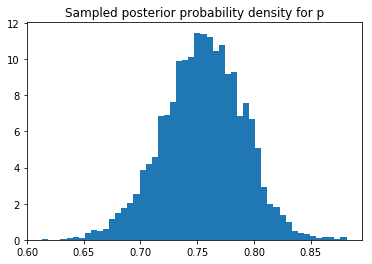

In [8]:
# Finally, we can extract the samples generated by Stan so that we
# can plot them or calculate any other functions or expected values
# we might be interested in.

posterior_samples = stan_results.extract()
plt.hist(posterior_samples['p'], bins=50, density=True)
plt.title('Sampled posterior probability density for p')
print(
    "Posterior 95% confidence interval for p:",
    np.percentile(posterior_samples['p'], [2.5, 97.5]))
plt.show()

## Task 1
* Reuse the code above to calculate the posterior 95% confidence interval for the probability of improvement in the **control group**.
* Plot the posterior histograms of the probability of improvement in the treatment and control groups on the same figure.

('Posterior 95% confidence interval for p:', array([0.38562514, 0.56005166]))


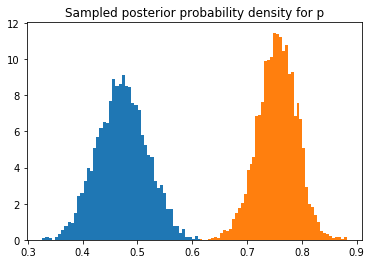

In [10]:
stan_control_results = stan_model.sampling(data=eczema_data['control'])
posterior_control_samples = stan_control_results.extract()
plt.hist(posterior_control_samples['p'], bins=50, density=True)
plt.hist(posterior_samples['p'], bins=50, density=True)
plt.title('Sampled posterior probability density for p')
print("Posterior 95% confidence interval for p:",
    np.percentile(posterior_control_samples['p'], [2.5, 97.5]))
plt.show()

## Task 2
* Using the samples from the treatment and control group posteriors, estimate the probability that treatment is at least 19% (in absolute terms) better than control, $P(p_t > p_c + 0.19)$. We computed this result in Session 3.2 where we solved the same model analytically using the algebra of conjugate distributions.

In [13]:
np.array(posterior_control_samples)

array(OrderedDict([(u'p', array([0.42469449, 0.50156606, 0.46478679, ..., 0.45560313, 0.51428262,
       0.38154627])), (u'lp__', array([-85.60585635, -85.27963152, -85.06909243, ..., -85.12071356,
       -85.50731721, -87.1189812 ]))]), dtype=object)

In [16]:
# Using sampling from posteriors
p_treatment_better = np.mean(
    posterior_samples['p'] > 0.19 + posterior_control_samples['p'])
print(p_treatment_better)

0.94775
